# TD7 : Bâtir un dictionnaire, extraire des néologismes candidats

## 0. Imports, fonctions et quelques variables

In [52]:
import json
import re
from pathlib import Path
from typing import Set
from collections import Counter

from bs4 import BeautifulSoup
from matplotlib import pyplot as plt


def get_voc(texte: str) -> Set[str]:
    """Renvoie le vocabulaire d'un texte (ensemble des mots uniques)"""
    return set(regex_decoupe.findall(texte))


path = "Corpus/Annee1999/"
path_fichier1 = path + "1999-05-17.xml"

regex_decoupe = re.compile(r"[a-zA-Z0-9À-ÿ]+")

In [53]:
with open(path_fichier1, encoding="utf-8") as f:
    html_doc = f.read()

soup = BeautifulSoup(html_doc, 'lxml')

/home/marceau/dico_neo/venv/lib/python3.11/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


## Exercice 1 : Acquérir une photographie de la Langue

In [54]:
for cpt_txt, d in enumerate(soup.find_all("div", type="article")[:10], 1):
    print(f"Article {cpt_txt}")
    txt = d.text
    # comparer le découpage en mots d'un split avec l'expression régulière du moodle)
    # travailler sur un échantillon de 10 articles

    mots_split = txt.split()  # découper avec split ##split sur les espaces
    mots_regex = regex_decoupe.findall(txt)  # découper avec la regexp

    # regarder ce qui est commun et ce qui est dans une tokénisation et pas dans l'autre
    set_split, set_regex = set(mots_split), set(mots_regex)

    intersection = set_split.intersection(set_regex)
    union = set_split.union(set_regex)
    # que_dans_un = set_split.symmetric_difference(set_regex)
    diff_split = set_split.difference(set_regex)
    diff_regex = set_regex.difference(set_split)

    if intersection == union:
        print("Les deux versions sont identiques")
        print(f"Pourcentage de mots en commun (rapport intersection sur union) : 100%\n\n")
        continue

    if diff_split:
        print(
            f"Les mots suivants ne sont pas dans la version regexp : {diff_split} cela représente {len(diff_split) / len(set_split) * 100 :.2f}% des mots du set")
    if diff_regex:
        print(
            f"Les mots suivants ne sont pas dans la version split : {diff_regex} cela représente {len(diff_regex) / len(set_regex) * 100 :.2f}% des mots du set")

    print(
        f"Pourcentage de mots en commun (rapport intersection sur union) : {len(intersection) / len(union) * 100 :.2f}%\n\n")


Article 1
Les mots suivants ne sont pas dans la version regexp : {'Saint-Mihiel'} cela représente 6.67% des mots du set
Les mots suivants ne sont pas dans la version split : {'Saint', 'Mihiel'} cela représente 12.50% des mots du set
Pourcentage de mots en commun (rapport intersection sur union) : 82.35%


Article 2
Les mots suivants ne sont pas dans la version regexp : {'Monde,', ':', "l'article", 'Société,'} cela représente 14.29% des mots du set
Les mots suivants ne sont pas dans la version split : {'article', 'Monde', 'l', 'Société'} cela représente 14.29% des mots du set
Pourcentage de mots en commun (rapport intersection sur union) : 75.00%


Article 3
Les mots suivants ne sont pas dans la version regexp : {"c'est", 'communes,', 'Vingt-cinq', 'veine.', "qu'entre", 'département.', 'passionnées,', "d'abord", 'légendaire,', 'jamais.', 'apprécié,', 'essences,', 'appuyé,'} cela représente 23.21% des mots du set
Les mots suivants ne sont pas dans la version split : {'appuyé', 'communes'

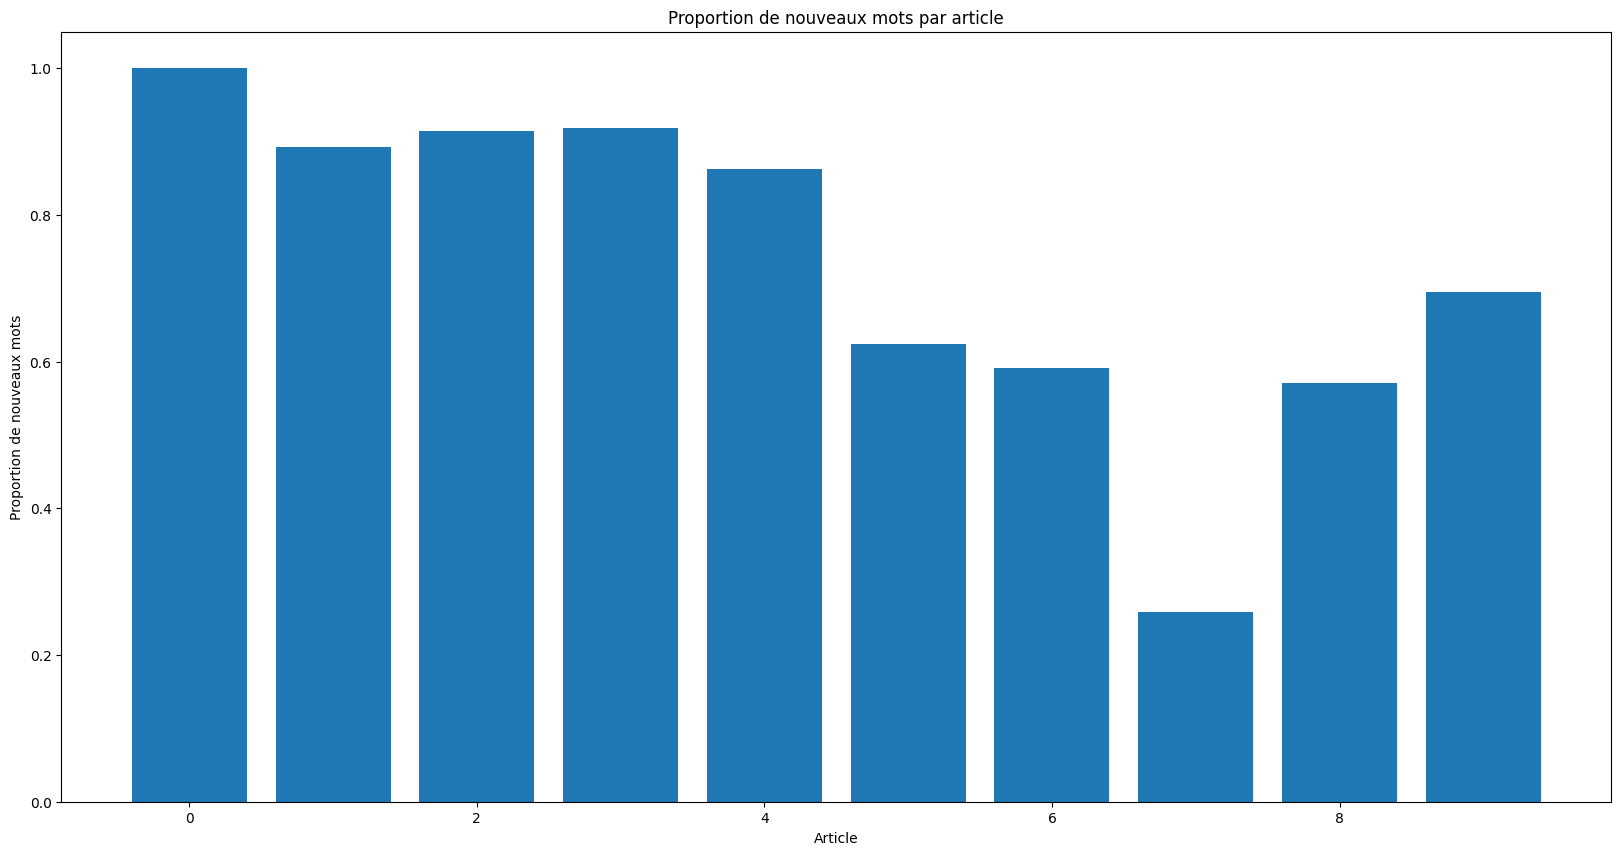

In [55]:
vocabulaire_jour = set()
mots_par_article = []
nouveaux_mots_par_article = []

for i, d in enumerate(soup.find_all("div", type="article")[:10], 1):
    texte = d.text
    vocabulaire_article = get_voc(texte)

    mots_par_article.append(vocabulaire_article)
    nouveaux_mots_par_article.append(vocabulaire_article.difference(vocabulaire_jour))
    vocabulaire_jour.update(vocabulaire_article)

proportion_nouveaux_mots_par_article = [(len(x)) / len(y) for x, y in zip(nouveaux_mots_par_article, mots_par_article)]

plt.figure(figsize=(20, 10))
plt.bar(range(len(proportion_nouveaux_mots_par_article)), proportion_nouveaux_mots_par_article)
plt.title("Proportion de nouveaux mots par article")
plt.xlabel("Article")
plt.ylabel("Proportion de nouveaux mots")
plt.show()

## Exercice 2 : Comparaisons d’un jour sur l’autre

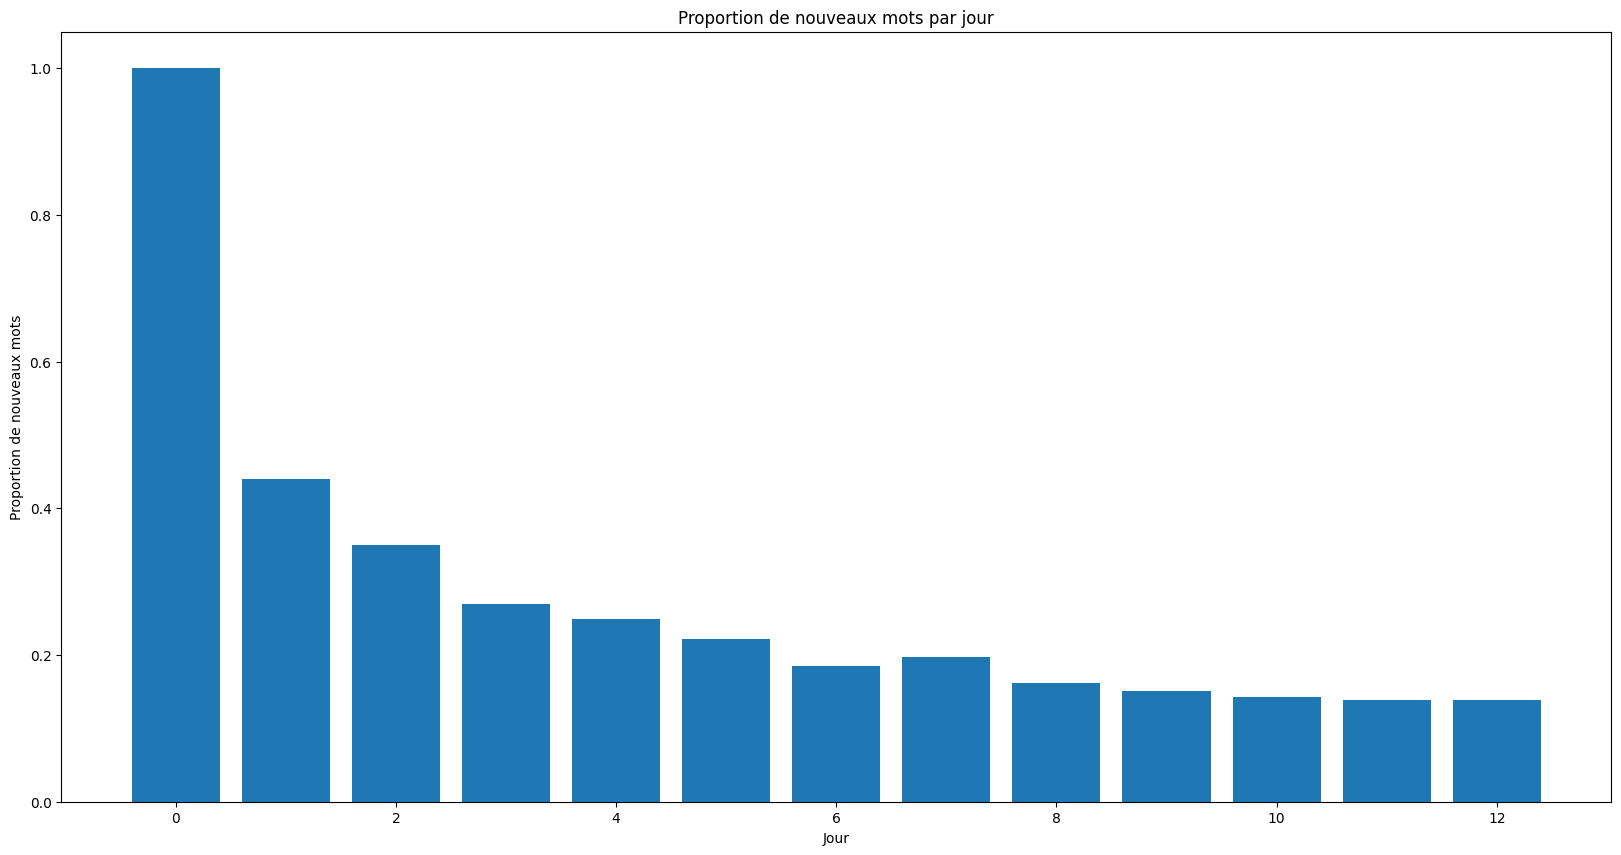

In [56]:
path = Path("Corpus/Annee1999/")
fichiers = list(path.glob("*.xml"))

# Ouvrir le fichier de sauvegarde, s'il n'existe pas, initialiser les variables à vide
try:
    with open("savestate.json", "r", encoding="utf-8") as f:
        savestate = json.load(f)
    vocabulaire_journalier = set(savestate["vocabulaire_journalier"])
    mots_par_jour = [set(x) for x in savestate["mots_par_jour"]]
    nouveaux_mots_par_jour = [set(x) for x in savestate["nouveaux_mots_par_jour"]]
    jours_faits = set(savestate["jours_faits"])
    del savestate

except FileNotFoundError:
    vocabulaire_journalier = set()
    mots_par_jour = []
    nouveaux_mots_par_jour = []
    jours_faits = set()

for jour in fichiers:
    if jour.as_posix() in jours_faits:
        continue

    with open(jour, encoding="utf-8") as f:
        html_doc = f.read()

    soup = BeautifulSoup(html_doc, 'lxml')

    texte = " ".join([d.text for d in soup.find_all("div", type="article")])

    vocabulaire_jour = get_voc(texte)

    mots_par_jour.append(vocabulaire_jour)
    nouveaux_mots_par_jour.append(vocabulaire_jour.difference(vocabulaire_journalier))
    vocabulaire_journalier.update(vocabulaire_jour)

    jours_faits.add(jour.as_posix())

    if len(jours_faits) % 10 == 0 or len(jours_faits) == len(fichiers):
        with open("savestate.json", "w", encoding="utf-8") as f:
            json.dump({
                "vocabulaire_journalier": list(vocabulaire_journalier),
                "mots_par_jour": [list(x) for x in mots_par_jour],
                "nouveaux_mots_par_jour": [list(x) for x in nouveaux_mots_par_jour],
                "jours_faits": list(jours_faits)
            }, f, indent=4, ensure_ascii=False)

proportion_nouveaux_mots_par_jour = [(len(x)) / len(y) for x, y in zip(nouveaux_mots_par_jour, mots_par_jour)]

plt.figure(figsize=(20, 10))
plt.bar(range(len(proportion_nouveaux_mots_par_jour)), proportion_nouveaux_mots_par_jour)
plt.title("Proportion de nouveaux mots par jour")
plt.xlabel("Jour")
plt.ylabel("Proportion de nouveaux mots")
plt.show()


## Exercice 3 : Analyse

Glaff et casse

In [57]:
# On charge le fichier glaff et on le traite pour ne pas le faire à chaque fois
with open("glaff-1.2.2.txt", encoding="utf-8") as f:
    glaff = f.read()

# pour chaque ligne, on prend le premier élément (avant le |) et on le met en minuscule
glaff = set([x.split("|")[0].lower() for x in glaff.splitlines()])

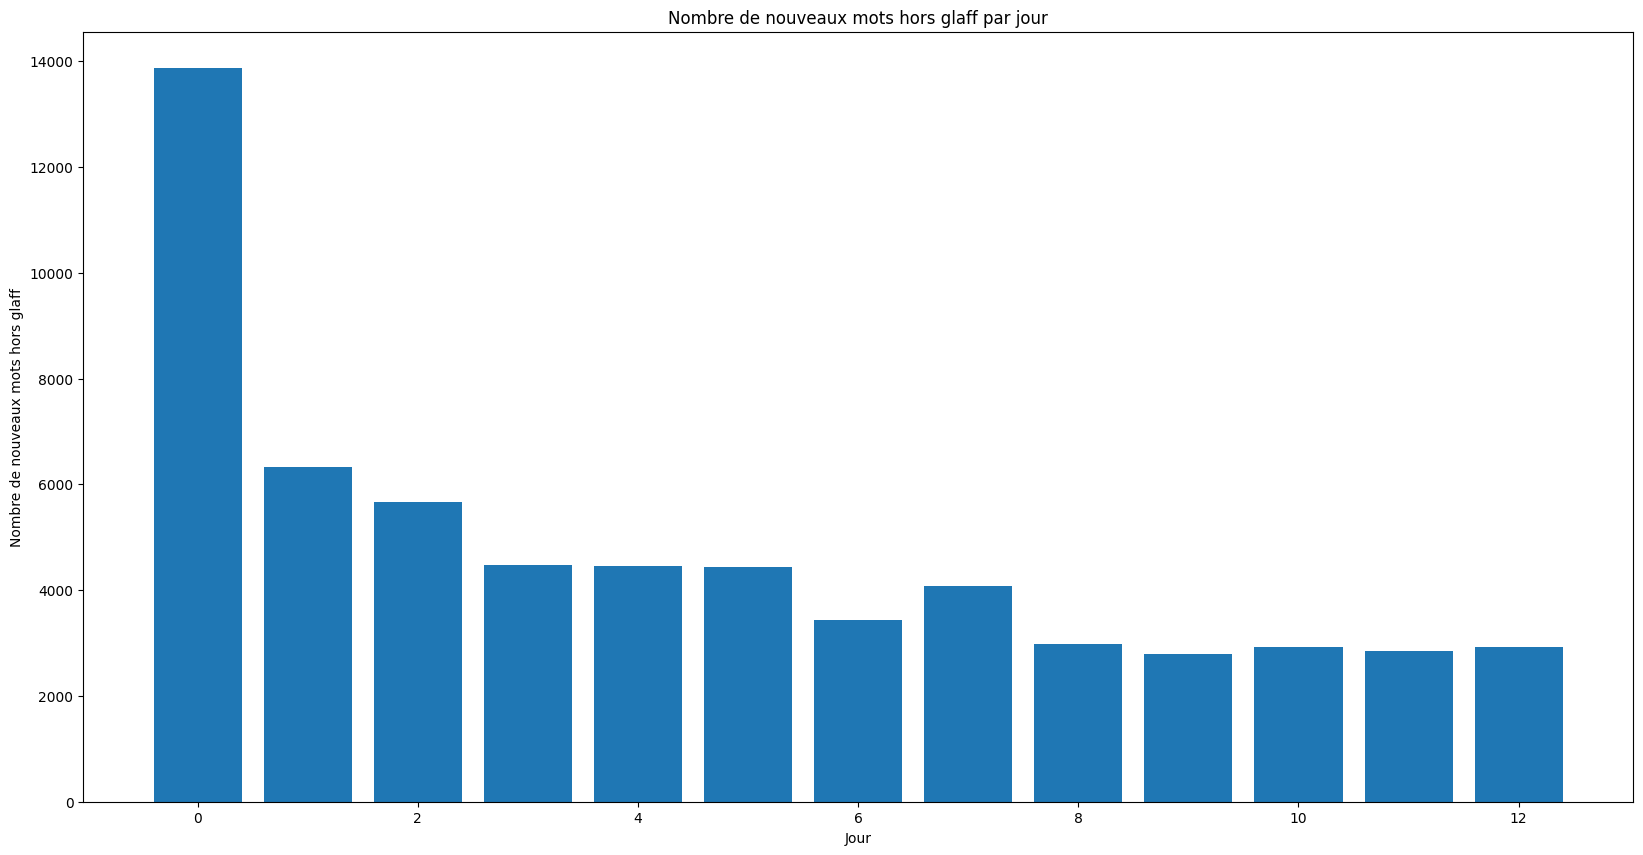

In [58]:
hors_glaff = []
majuscules = []
minuscules = []
for jour in nouveaux_mots_par_jour:
    hors_glaff.append(jour.difference(glaff))
    majuscules.append([x for x in jour if x[0].isupper()])
    minuscules.append([x for x in jour if x[0].islower()])

plt.figure(figsize=(20, 10))
plt.bar(range(len(hors_glaff)), [len(x) for x in hors_glaff])
plt.title("Nombre de nouveaux mots hors glaff par jour")
plt.xlabel("Jour")
plt.ylabel("Nombre de nouveaux mots hors glaff")
plt.show()


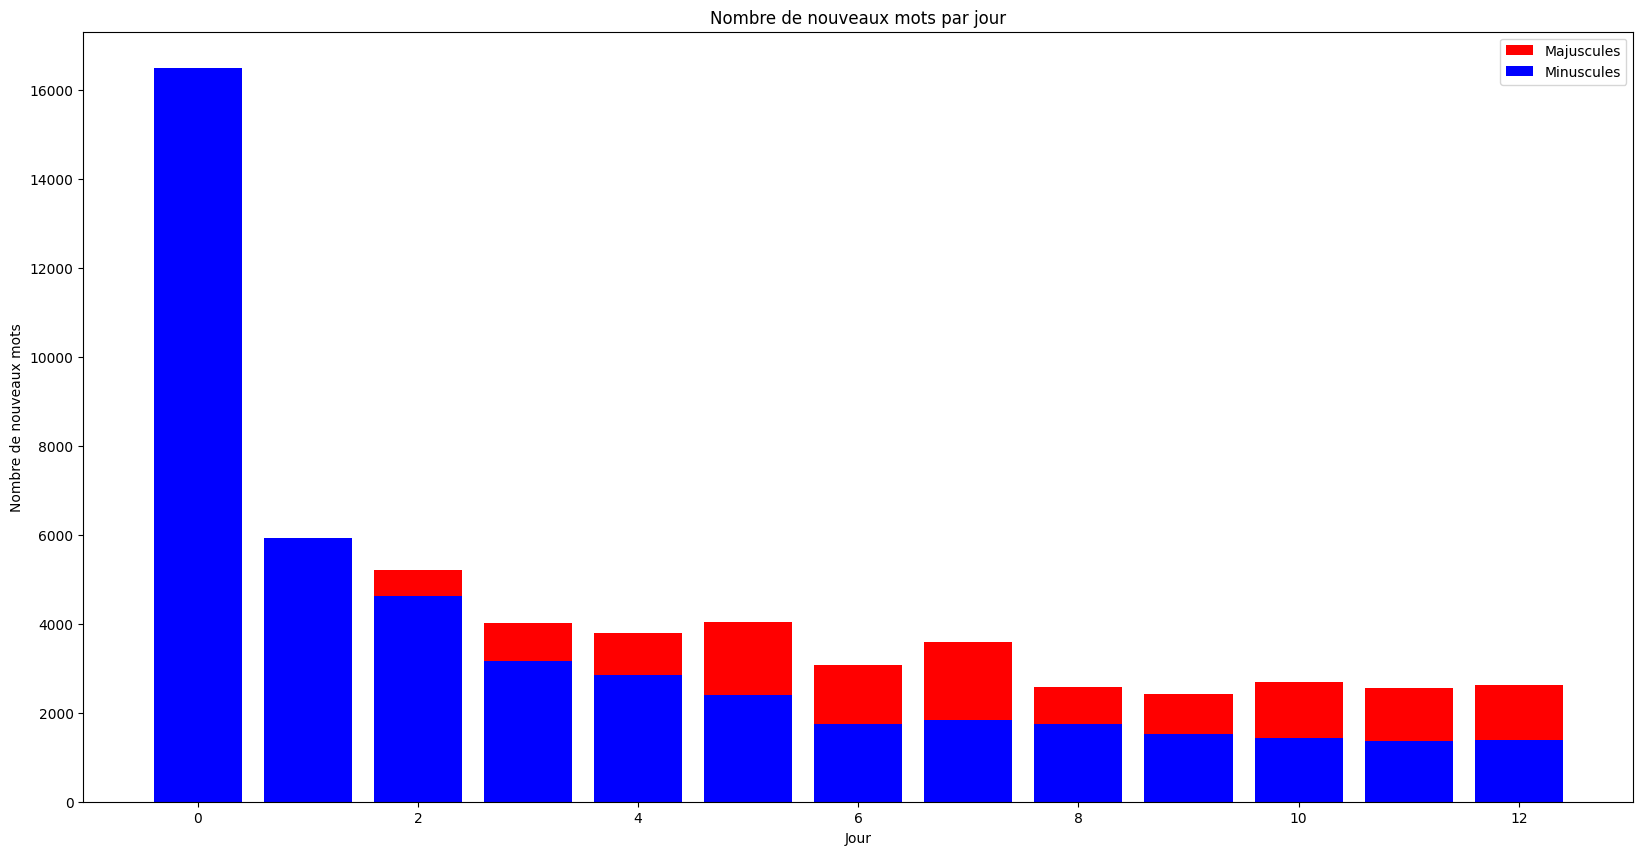

In [59]:
plt.figure(figsize=(20, 10))
plt.bar(range(len(majuscules)), [len(x) for x in majuscules], color="red", label="Majuscules")
plt.bar(range(len(minuscules)), [len(x) for x in minuscules], color="blue", label="Minuscules")
plt.title("Nombre de nouveaux mots par jour")
plt.xlabel("Jour")
plt.ylabel("Nombre de nouveaux mots")
plt.legend()
plt.show()


Longueur des mots

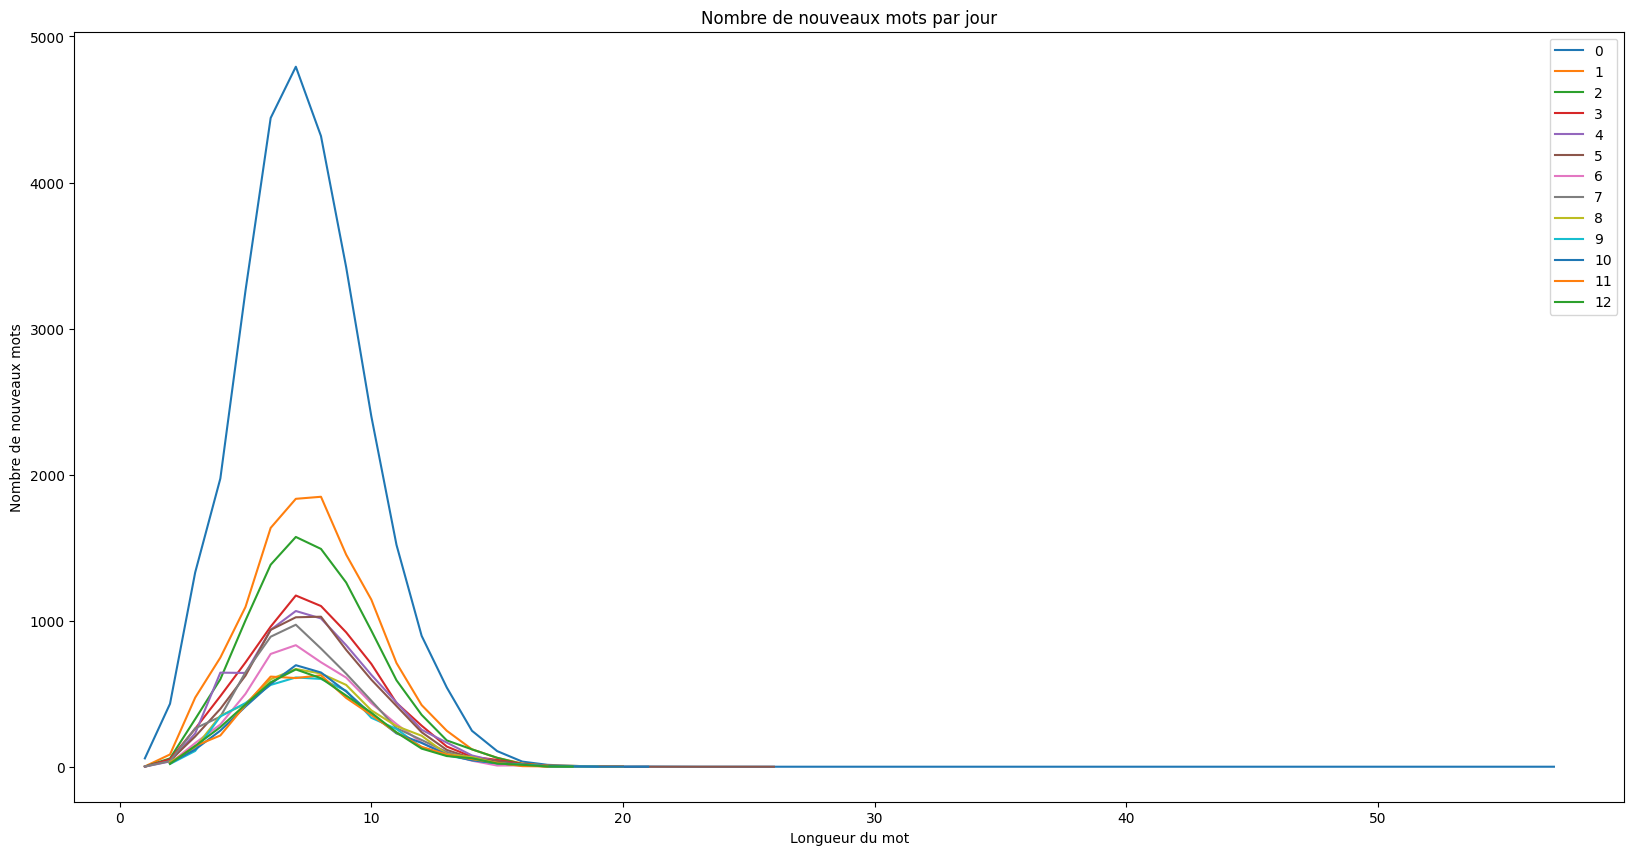

In [60]:
selon_taille_par_jour = []
for jour in nouveaux_mots_par_jour:
    tup = sorted(tuple(Counter([len(x) for x in jour]).items()))
    selon_taille_par_jour.append(tup)

plt.figure(figsize=(20, 10))
for i, jour in enumerate(selon_taille_par_jour):
    plt.plot([x[0] for x in jour], [x[1] for x in jour], label=i)
plt.title("Nombre de nouveaux mots par jour")
plt.xlabel("Longueur du mot")
plt.ylabel("Nombre de nouveaux mots")
plt.legend()
plt.show()


Zoom sur la partie intéressante

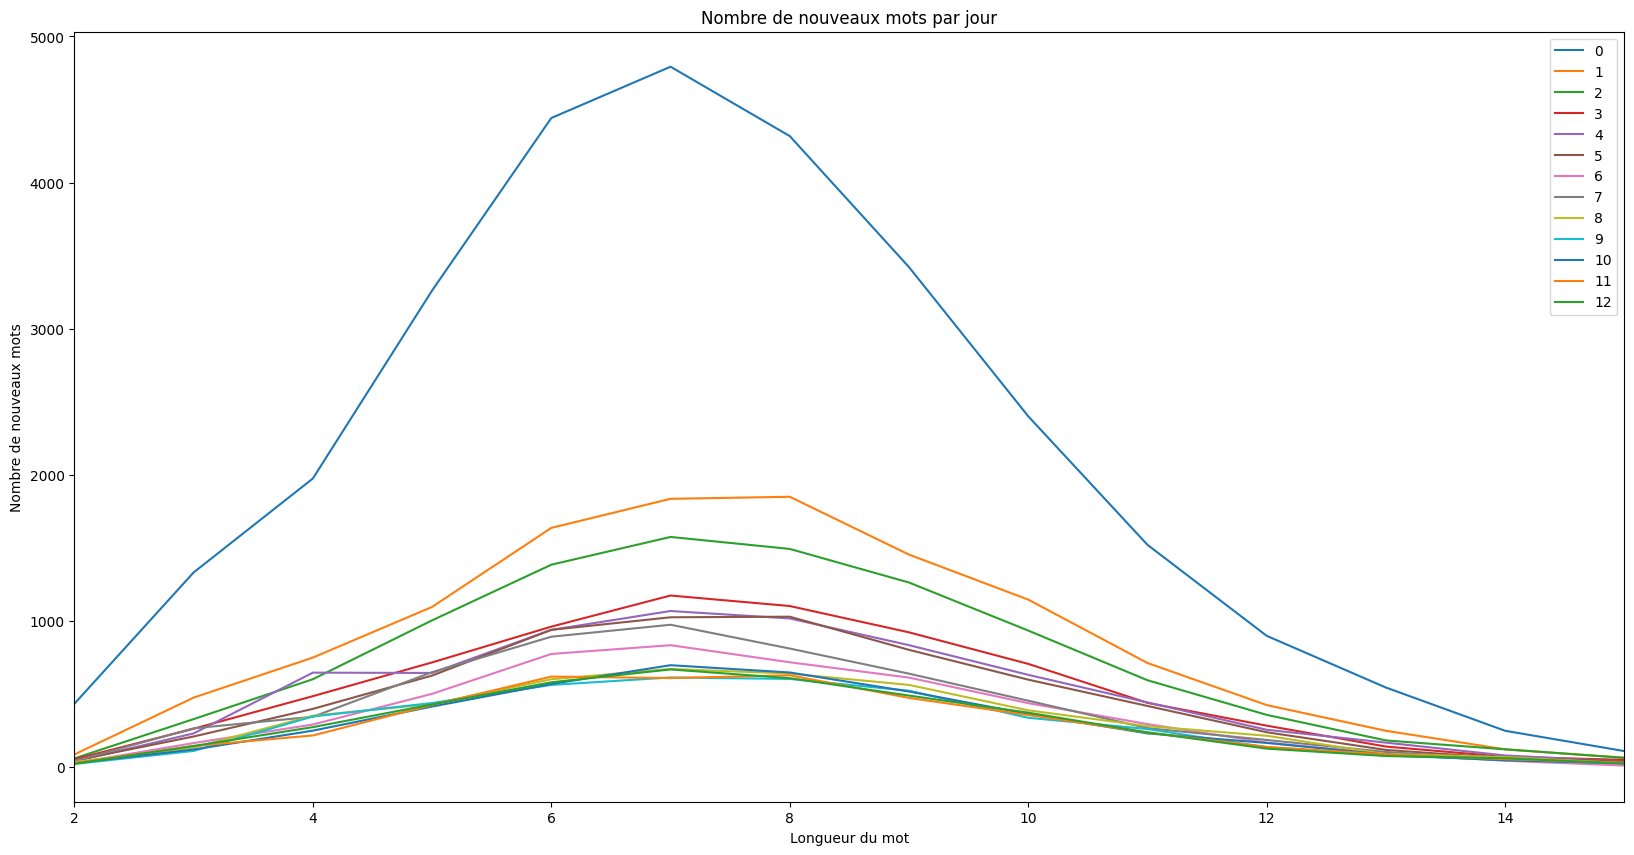

In [61]:
plt.figure(figsize=(20, 10))
for i, jour in enumerate(selon_taille_par_jour):
    plt.plot([x[0] for x in jour], [x[1] for x in jour], label=i)
plt.title("Nombre de nouveaux mots par jour")
plt.xlabel("Longueur du mot")
plt.ylabel("Nombre de nouveaux mots")
plt.legend()
plt.xlim(2, 15)
plt.show()

On constate du coup un pic important dans le graphe pour les mots d'une longueur comprise entre 4/5 et 9/10 caractères.
On peut donc supposer que les mots de longueur inférieure à 6 caractères sont des mots très courants, comme les mots outils, les verbes conjugués, etc.
Et que les mots de longueur supérieure à 9 caractères sont des mots un peu plus rares, qui apparaissent moins souvent de manière générale.
